In [4]:
# Data reading and processing
import re
import pandas as pd
import numpy as np
import warnings
import time
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from datetime import datetime

import os
from os import path

# Visualisation
from matplotlib import pyplot as plt
#from pandas_ml import ConfusionMatrix

# Modelling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBClassifier, XGBRegressor
#from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, mean_squared_error

# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
# Setting current directory as same directory where code is stored
try:
    CUR_DIR = '/content/drive/MyDrive'
except NameError:
    CUR_DIR = os.getcwd()

In [6]:
# Additional functions
## Print confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

        
def create_clustered_bar(matrix, axis):
    bar_renderers = []
    x = np.arange(matrix.shape[0])
    dx = (np.arange(matrix.shape[1])-matrix.shape[1]/2.)/(matrix.shape[1]+2.)
    d = 1./(matrix.shape[1]+2.)

    for i in range(matrix.shape[1]):
        r = axis.bar(x+dx[i],matrix[:,i], width=d)
        bar_renderers.append(r)
    return bar_renderers
 
    
## Calculating distance        
def pythagoras(long1, long2, lat1, lat2):
    import math
    a = abs(long1-long2)**2
    b = abs(lat1-lat2)**2
    return math.sqrt(a+b)

In [10]:
# # Import data files
#fp = os.path.join(CUR_DIR,"input")

train = pd.read_csv(path.join(CUR_DIR, 'TrainingData.csv'),index_col=None)
test = pd.read_csv(path.join(CUR_DIR, 'ValidationData.csv'),index_col=None)
print('Training dataset (length, width) = {}'.format(str(train.shape)))
print('Validation dataset (length, width) = {}'.format(str(test.shape)))

Training dataset (length, width) = (19937, 529)
Validation dataset (length, width) = (1111, 529)


In [11]:
# removing columns
sub_train = train[[x for x in train.columns if 'WAP' not in x]]
sub_train['max_signal'] = train.loc[:,[x for x in train.columns if 'WAP' in x]].replace(100,np.NaN).max(axis=1)
nan_sub = sub_train.loc[np.isnan(sub_train['max_signal']),]
nan_rows = sub_train['max_signal'].isnull().sum()
nan_rows_index = nan_sub.index.tolist()
train = train.iloc[[x for x in train.index if x not in nan_rows_index]]
wap_max = train[[x for x in train.columns if 'WAP' in x]].replace(100,np.nan).max(axis=0).reset_index()
wap_max = wap_max.rename(columns={'index':'wap_name', 0: 'max_signal'}).fillna(10)
cols_torm = wap_max.loc[wap_max['max_signal']==10,'wap_name'].tolist()
train = train.drop(train[cols_torm],axis=1)
test = test.drop(test[cols_torm],axis=1)

print('Number of WAP variables removed: {}'.format(len(cols_torm)))
print('Remaining WAP variables: {}'.format(len([x for x in train.columns if 'WAP' in x])))

Number of WAP variables removed: 55
Remaining WAP variables: 465


## **| Predictive Modelling**

- Classification Algorithms
  - Input variables: WAP001 to WAP520
  - Excluding the 55 WAP variables with no RSSI readings

- Target variables: Building and Floor
  - Total classes: 13 (cross join of all available buildings and floors)

In [12]:
# Creates single variable combining both targets
train['target'] = 'B' + train['BUILDINGID'].astype(str) + ' x F' + train['FLOOR'].astype(str)
test['target'] = 'B' + test['BUILDINGID'].astype(str) + ' x F' + test['FLOOR'].astype(str)

In [15]:
class_models = []
class_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
class_models.append(('Decision Tree', DecisionTreeClassifier(random_state=20)))
class_models.append(('Random Forest', RandomForestClassifier(random_state=20)))
class_models.append(('Neural Network', MLPClassifier(random_state=20)))
#class_models.append(('XGBoost', XGBClassifier(random_state=20)))
#class_models.append(('CatBoost', CatBoostClassifier(silent=True,iterations=200,random_seed=20)))

# evaluate each model in turn
class_results = []
class_names = []
for name, model in class_models:
    st = time.time()
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel(), cv=kfold, scoring='accuracy',n_jobs=-1)
    class_results.append(cv_results)
    class_names.append(name)
    print("{}: {:.4f} ({:.4f})".format(name, cv_results.mean(), cv_results.std()))
    print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

Linear Discriminant Analysis: 0.6927 (0.1543)
	Time elapsed: 15.77 seconds
Decision Tree: 0.6480 (0.1650)
	Time elapsed: 2.74 seconds
Random Forest: 0.7660 (0.2015)
	Time elapsed: 18.25 seconds
Neural Network: 0.7348 (0.1194)
	Time elapsed: 94.44 seconds


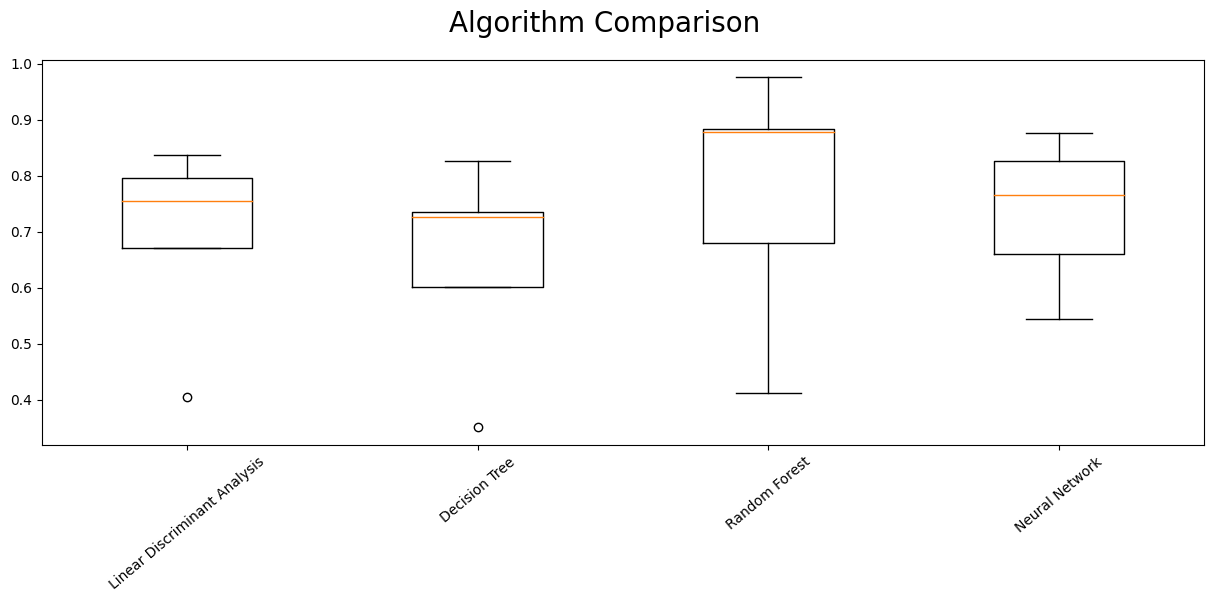

In [16]:
# Compare Algorithms
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(class_results)
ax.set_xticklabels(class_names,rotation=40)
plt.show()

In [22]:
st = time.time()
original_class_params = {
  #"learning_rate":0.1,
  "n_estimators":100,
  "max_depth":5,
  #"min_child_weight":1,
  #"gamma":0,
  #"alpha":0,
  #"lambda":1,
}
class_xg = RandomForestClassifier(**original_class_params,n_jobs=-1)
class_xg.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
class_preds = class_xg.predict(test[[x for x in train.columns if 'WAP' in x]])
print("Accuracy: {:.2f}%".format(accuracy_score(test['target'].ravel(), class_preds)*100))
print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

Accuracy: 64.09%
	Time elapsed: 2.76 seconds
